# Multi-Agent Reinforcement Learning Benchmark on Highway Environment for Autonomous Driving
Highway Environment for Autonomous Driving
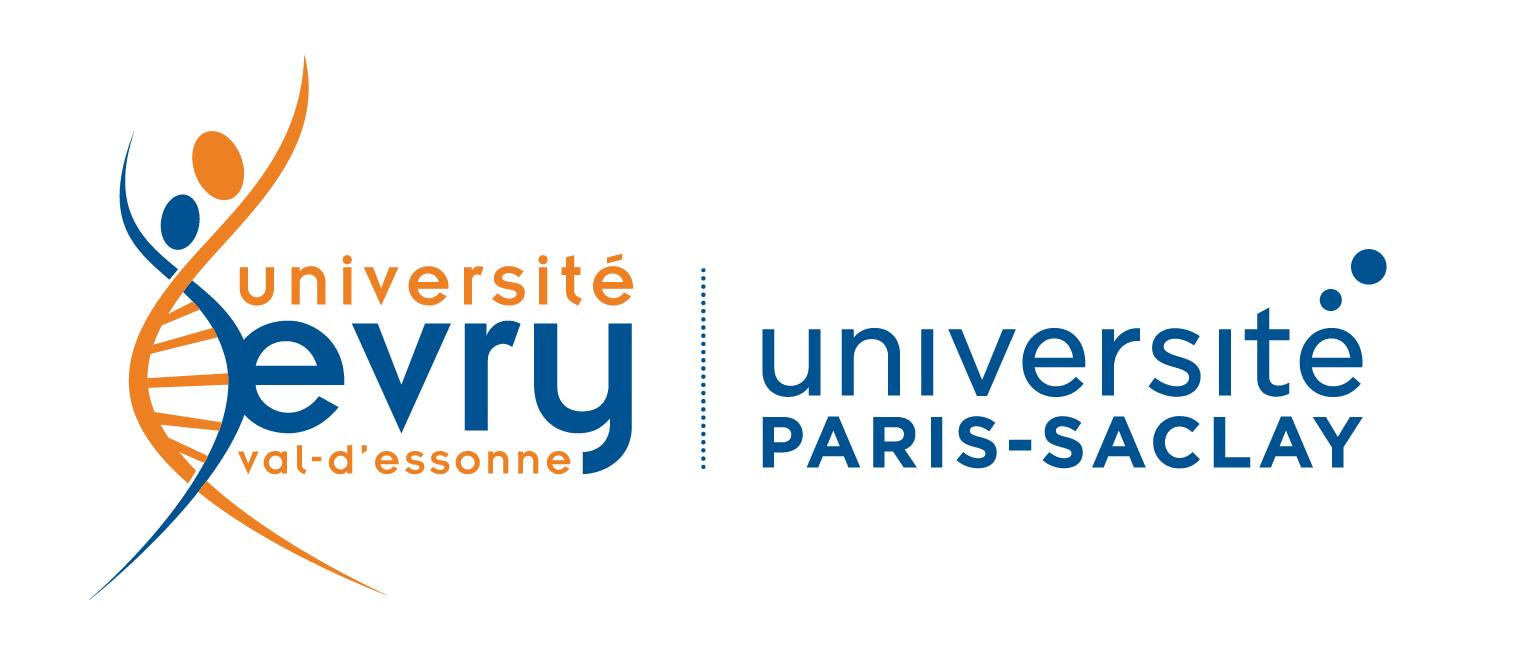
 **Prepared by: Charbel ABI HANA**

In [ ]:
# Packages required
# !pip install gym highway-env pfrl pyvirtualdisplay

### Training - IDQN/IPPO

#### Imports

In [1]:
import gym
import highway_env
import pfrl
import numpy as np
import torch
import torch.nn as nn

from typing import Tuple

from highway_env import utils

import pfrl.initializers

from pfrl.nn import Branched
from pfrl.agents import PPO
from pfrl.policies import SoftmaxCategoricalHead
from pfrl import explorers, replay_buffers
from pfrl.explorer import Explorer
from pfrl.agents import DQN
from pfrl.q_functions import DiscreteActionValueHead
from pfrl.utils.contexts import evaluating

from matplotlib import pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

from tqdm.notebook import trange

import sys

sys.path.insert(0, 'highway-env/scripts/')
from utils import record_videos, show_videos

In [2]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
from pathlib import Path
import base64

#disp=Display(backend="xvfb")

display = Display(visible=True, size=(1400, 900), backend="xvfb")
display.start()

In [3]:
from IPython import display

def show_state(env, is_ipython, step):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(f"Step: {step}")
    
    plt.pause(0.001)  # pause for plots to update

    if is_ipython:
        display.clear_output(wait=True)

In [4]:
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [5]:
!pip install imageio-ffmpeg

In [6]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=True, interval=80):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [7]:
def record_videos(env, video_folder="videos"):
    wrapped = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

#### Environment Init

In [8]:
env = gym.make('highway-v0')
env.seed(0)

[0]

##### Environment Config

In [9]:
env.configure({
  "controlled_vehicles": 3,
  "ego_spacing": 1,
  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
      "vehicles_count": 10,
      "features": ["presence", "x", "y", "vx", "vy", "cos_h"],
      "features_range": {
          "x": [-600, 600],
          "y": [-100, 100],
          "vx": [-30, 30],
          "vy": [-30, 30]
      },
      "absolute": False,
      "normalize": False,
      "order": "sorted"
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  },
    'simulation_frequency': 60,
    "vehicles_count": 10,
    "vehicles_density": 5,
    "show_trajectories": False,
    "screen_width": 600,
    "screen_height": 300
})

#### Wrap Reward Function for Multi-Agent Setting

In [10]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env
    
    def reward(self, reward):
        # Placeholder actions, values won't be used
        actions = range(5)
        ego_vehicles = self.env.controlled_vehicles
        reward_per_vehicle = {}
        for action, vehicle in zip(actions, ego_vehicles):
            reward_per_vehicle[vehicle] = self._reward_per_vehicle(action, vehicle)
            
        return reward_per_vehicle
    
    def _reward_per_vehicle(self, action, vehicle: highway_env.vehicle.controller.MDPVehicle):
        """
        The reward is defined to foster driving at high speed, on the rightmost lanes, and to avoid collisions.
        :param action: the last action performed
        :return: the corresponding reward
        """
        neighbours = self.env.road.network.all_side_lanes(vehicle.lane_index)
        lane = vehicle.target_lane_index[2] if isinstance(vehicle, highway_env.vehicle.controller.ControlledVehicle) \
            else vehicle.lane_index[2]
        # Use forward speed rather than speed, see https://github.com/eleurent/highway-env/issues/268
        forward_speed = vehicle.speed * np.cos(vehicle.heading)
        scaled_speed = utils.lmap(forward_speed, self.env.config["reward_speed_range"], [0, 1])
        reward = \
            + self.env.config["collision_reward"] * vehicle.crashed \
            + self.env.config["right_lane_reward"] * lane / max(len(neighbours) - 1, 1) \
            + self.env.config["high_speed_reward"] * np.clip(scaled_speed, 0, 1)
        reward = utils.lmap(reward,
                          [self.env.config["collision_reward"],
                           self.env.config["high_speed_reward"] + self.env.config["right_lane_reward"]],
                          [0, 1])
        reward = 0 if not vehicle.on_road else reward
        return reward

In [11]:
env = RewardWrapper(env)

#### Some Environment Visuals

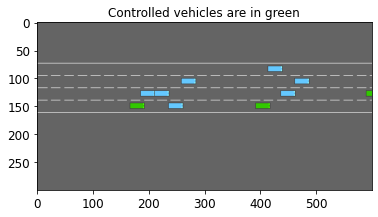

In [12]:
env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.title("Controlled vehicles are in green")
plt.show()

#### Developing IDQN Agent

In [34]:
class Agent(object):
    def __init__(self):
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        self.device = torch.device(device)

    def act(self, observation):
        raise NotImplementedError

    def observe(self, observation, reward, done, info):
        raise NotImplementedError


class IndependentAgent(Agent):
    def __init__(self, config, obs_act):
        super().__init__()
        self.config = config
        self.agents = dict()

    def act(self, observation):
        acts = dict()
        for agent_id in observation.keys():
            acts[agent_id] = self.agents[agent_id].act(observation[agent_id])
        return acts

    def observe(self, observation, reward, done, info):
        for agent_id in observation.keys():
            self.agents[agent_id].observe(observation[agent_id], reward[agent_id], done, info)
            if done:
                if info['eps'] % 100 == 0:
                    self.agents[agent_id].save(self.config['log_dir']+'agent_'+agent_id)

In [35]:
class DQNAgent(Agent):
    def __init__(self, config, act_space, model):
        super().__init__()

        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters())
        replay_buffer = replay_buffers.ReplayBuffer(10000)


        explorer = explorers.LinearDecayEpsilonGreedy(
            config['EPS_START'],
            config['EPS_END'],
            config['steps'],
            lambda: np.random.randint(act_space),
        )

        self.agent = DQN(self.model, self.optimizer, replay_buffer, config['GAMMA'], explorer,
                         
                         minibatch_size=config['BATCH_SIZE'], replay_start_size=config['BATCH_SIZE'],
                         phi=lambda x: np.asarray(x, dtype=np.float32),
                         target_update_interval=config['TARGET_UPDATE'])

    def act(self, observation):
        return self.agent.act(observation)

    def observe(self, observation, reward, done, info):
        self.agent.observe(observation, reward, done, False)

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path+'.pt')
        
    def get_statistics(self):
        return self.agent.get_statistics()

In [36]:
class IDQN(IndependentAgent):
    def __init__(self, config, obs_act):
        super().__init__(config, obs_act)
        for key in obs_act:
            obs_space = obs_act[key][0]
            act_space = obs_act[key][1]

            def conv2d_size_out(size, kernel_size=2, stride=1):
                return (size - (kernel_size - 1) - 1) // stride + 1

            h = conv2d_size_out(obs_space[1])
            w = conv2d_size_out(obs_space[2])

            model = nn.Sequential(
                nn.Conv2d(obs_space[0], 64, kernel_size=(2, 2)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(h * w * 64, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, act_space),
                DiscreteActionValueHead()
            )

            self.agents[key] = DQNAgent(config, act_space, model)
    
    def get_statistics(self):
        for agent in self.agents:
            print(self.agents[agent].get_statistics())

In [37]:
def develop_observations(env_obs: Tuple[np.ndarray]):
    return {f"vehicle_{i}":obs[np.newaxis] for i, obs in enumerate(env_obs)}

##### IDQN Configurable Parameters

In [38]:
config = {'BATCH_SIZE': 32,
'GAMMA': 0.8,
'EPS_START': 1.0,
'EPS_END': 0.0,
'TARGET_UPDATE': 100,
'steps': 1.0,
'log_dir': 'idqn_logs/'}

In [39]:
controlled_vehicles = 3
actions = 5
observation_space_batched = (1, 10, 6)
obs_act = {f"vehicle_{i}":(observation_space_batched, actions) for i in range(controlled_vehicles)}

In [40]:
idqn_agent = IDQN(config= config, obs_act= obs_act)

#### IDQN Training Loop

In [20]:
EPISODES = 1000
store_at_episodes = [1, 10, 50, 250]

EPISODE_DURATION = 40

In [21]:
img_frames = []
reward_hist = []
score_history = []

for episode in trange(EPISODES, desc= "Training Episodes"):
    img_frames_per_episode = []

    step_reward = []
    
    scores = []
    score = 0
    
    done = False
    store = False
    
    obs = env.reset()
    developed_obs = {f"vehicle_{i}":obs_[np.newaxis] for i, obs_ in enumerate(obs)}
    
    if episode in store_at_episodes:
        store = True
        
    i = 0
    while not done:
        # shows gif of each episode in jupyt
        # Dispatch the observations to the model to get the tuple of actions
        if store:
            img = env.render(mode="rgb_array")
            img_frames_per_episode.append(img)
            
        action = idqn_agent.act(developed_obs)
        full_action = tuple(action.values())
        # Execute the actions
        next_obs, rewards, done, info = env.step(full_action)
        done = any(tuple([info[vehicle]["crashed"] for vehicle in info if not (vehicle == "eps")]))
        if i > EPISODE_DURATION:
            break
            
        if store:
            img = env.render(mode="rgb_array")
            img_frames_per_episode.append(img)

        rewards = {f"vehicle_{i}": reward for i, reward in enumerate(rewards.values())}
        info["eps"] += 1
        
        avg_cars_reward = np.mean(np.array(list(rewards.values())))
        score += avg_cars_reward
        scores.append(score)
        step_reward.append(avg_cars_reward)
        next_obs_full = {f"vehicle_{i}":obs[np.newaxis] for i, obs in enumerate(next_obs)}
        
        # Update the model with the transitions observed by each agent
        idqn_agent.observe(next_obs_full, rewards, done, info)
        env.render()
        i += 1
    ep_reward = np.mean(step_reward)
    score_history.append(np.mean(scores))
    print(f"Episode: {episode}/{EPISODES}; avg_reward: {ep_reward}, score: {np.mean(scores)}")
    #print(alg.get_statistics())
    if store:
        img_frames.append(img_frames_per_episode)
    reward_hist.append(ep_reward)

Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode: 0/1000; avg_reward: 0.04444444444444443, score: 0.04444444444444443
Episode: 1/1000; avg_reward: 0.5680651368999882, score: 0.5680651368999882
Episode: 2/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 3/1000; avg_reward: 0.5407407407407407, score: 0.5407407407407407
Episode: 4/1000; avg_reward: 0.051851851851851836, score: 0.051851851851851836
Episode: 5/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 6/1000; avg_reward: 0.3037037037037037, score: 0.3037037037037037
Episode: 7/1000; avg_reward: 0.5119025000115566, score: 0.5119025000115566
Episode: 8/1000; avg_reward: 0.2888888888888889, score: 0.2888888888888889
Episode: 9/1000; avg_reward: 0.29629629629629634, score: 0.29629629629629634
Episode: 10/1000; avg_reward: 0.5703703703703704, score: 0.5703703703703704
Episode: 11/1000; avg_reward: 0.562962962962963, score: 0.562962962962963
Episode: 12/1000; avg_reward: 0.6996263827376792, score: 1.4907815840848322
Episode: 13/1000

Episode: 108/1000; avg_reward: 0.6962962962962963, score: 1.1111111111111112
Episode: 109/1000; avg_reward: 0.27486546297451947, score: 0.27486546297451947
Episode: 110/1000; avg_reward: 0.6106444914667575, score: 1.3869848779990956
Episode: 111/1000; avg_reward: 0.5555555555555556, score: 0.5555555555555556
Episode: 112/1000; avg_reward: 0.5555555555555555, score: 0.5555555555555555
Episode: 113/1000; avg_reward: 0.3259259259259259, score: 0.3259259259259259
Episode: 114/1000; avg_reward: 0.519309907418964, score: 0.519309907418964
Episode: 115/1000; avg_reward: 0.3259259259259259, score: 0.3259259259259259
Episode: 116/1000; avg_reward: 0.3037037037037037, score: 0.3037037037037037
Episode: 117/1000; avg_reward: 0.5341247222337787, score: 0.5341247222337787
Episode: 118/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 119/1000; avg_reward: 0.5629629629629629, score: 0.5629629629629629
Episode: 120/1000; avg_reward: 0.7575639012728022, score: 2.365152308552059


Episode: 215/1000; avg_reward: 0.5200661353540627, score: 0.9060427094396932
Episode: 216/1000; avg_reward: 0.26005064815970474, score: 0.26005064815970474
Episode: 217/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 218/1000; avg_reward: 0.2888888888888889, score: 0.2888888888888889
Episode: 219/1000; avg_reward: 0.28148148148148144, score: 0.28148148148148144
Episode: 220/1000; avg_reward: 0.3075597059848751, score: 0.3075597059848751
Episode: 221/1000; avg_reward: 0.2896802777893343, score: 0.2896802777893343
Episode: 222/1000; avg_reward: 0.5761263452094272, score: 0.5761263452094272
Episode: 223/1000; avg_reward: 0.7572310513527825, score: 2.76522992796402
Episode: 224/1000; avg_reward: 0.26005064815970474, score: 0.26005064815970474
Episode: 225/1000; avg_reward: 0.655088935911202, score: 1.4758737668879844
Episode: 226/1000; avg_reward: 0.5555555555555555, score: 0.5555555555555555
Episode: 227/1000; avg_reward: 0.022222222222222216, score: 0.02222222222

Episode: 321/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 322/1000; avg_reward: 0.7115493129824391, score: 2.2378372386520637
Episode: 323/1000; avg_reward: 0.5044950926041492, score: 0.5044950926041492
Episode: 324/1000; avg_reward: 0.5044950926041492, score: 0.5044950926041492
Episode: 325/1000; avg_reward: 0.24523583334488994, score: 0.24523583334488994
Episode: 326/1000; avg_reward: 0.5341247222337788, score: 0.5341247222337788
Episode: 327/1000; avg_reward: 0.5119025000115566, score: 0.5119025000115566
Episode: 328/1000; avg_reward: 0.5341247222337788, score: 0.5341247222337788
Episode: 329/1000; avg_reward: 0.5637543518634084, score: 0.5637543518634084
Episode: 330/1000; avg_reward: 0.49787907409718724, score: 0.49787907409718724
Episode: 331/1000; avg_reward: 0.717923328902908, score: 3.44865799266772
Episode: 332/1000; avg_reward: 0.24523583334488985, score: 0.24523583334488985
Episode: 333/1000; avg_reward: 0.5481481481481482, score: 0.5481481481481

Episode: 428/1000; avg_reward: 0.519309907418964, score: 0.519309907418964
Episode: 429/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 430/1000; avg_reward: 0.6976005895701879, score: 1.833772965697436
Episode: 431/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 432/1000; avg_reward: 0.7412311490810783, score: 15.575551366727426
Episode: 433/1000; avg_reward: 0.49047166668977976, score: 0.49047166668977976
Episode: 434/1000; avg_reward: 0.5119025000115566, score: 0.5119025000115566
Episode: 435/1000; avg_reward: 0.5052864815045947, score: 0.5052864815045947
Episode: 436/1000; avg_reward: 0.5052864815045945, score: 0.5052864815045945
Episode: 437/1000; avg_reward: 0.7003148866677711, score: 2.196973182707766
Episode: 438/1000; avg_reward: 0.2748654629745195, score: 0.2748654629745195
Episode: 439/1000; avg_reward: 0.28148148148148144, score: 0.28148148148148144
Episode: 440/1000; avg_reward: 0.051851851851851836, score: 0.05185185185185

Episode: 534/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 535/1000; avg_reward: 0.022222222222222216, score: 0.022222222222222216
Episode: 536/1000; avg_reward: 0.49787907409718724, score: 0.49787907409718724
Episode: 537/1000; avg_reward: 0.519309907418964, score: 0.519309907418964
Episode: 538/1000; avg_reward: 0.2674580555671121, score: 0.2674580555671121
Episode: 539/1000; avg_reward: 0.6319334744002725, score: 1.0179100484859032
Episode: 540/1000; avg_reward: 0.5489395370485936, score: 0.5489395370485936
Episode: 541/1000; avg_reward: 0.6097112521780501, score: 0.9845767151525695
Episode: 542/1000; avg_reward: 0.3037037037037037, score: 0.3037037037037037
Episode: 543/1000; avg_reward: 0.6715222927556919, score: 1.0756216909096183
Episode: 544/1000; avg_reward: 0.7028634667970293, score: 1.4851738694913348
Episode: 545/1000; avg_reward: 0.5563469444560011, score: 0.5563469444560011
Episode: 546/1000; avg_reward: 0.7102708742044367, score: 1.499988684306

Episode: 641/1000; avg_reward: 0.7070337901450864, score: 1.5055963988996466
Episode: 642/1000; avg_reward: 0.5600506481597046, score: 0.5600506481597046
Episode: 643/1000; avg_reward: 0.5052864815045947, score: 0.5052864815045947
Episode: 644/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 645/1000; avg_reward: 0.26745805556711216, score: 0.26745805556711216
Episode: 646/1000; avg_reward: 0.5555555555555557, score: 0.5555555555555557
Episode: 647/1000; avg_reward: 0.7780229819479465, score: 16.343331238919273
Episode: 648/1000; avg_reward: 0.3136218361307439, score: 0.3136218361307439
Episode: 649/1000; avg_reward: 0.5159667372001362, score: 0.9089550242429514
Episode: 650/1000; avg_reward: 0.6658264297599922, score: 1.411099795417261
Episode: 651/1000; avg_reward: 0.5341247222337788, score: 0.5341247222337788
Episode: 652/1000; avg_reward: 0.49787907409718724, score: 0.49787907409718724
Episode: 653/1000; avg_reward: 0.6901931821627805, score: 1.8152544471789

Episode: 748/1000; avg_reward: 0.63934088180768, score: 1.0290211595970145
Episode: 749/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 750/1000; avg_reward: 0.5703703703703704, score: 0.5703703703703704
Episode: 751/1000; avg_reward: 0.28888888888888886, score: 0.28888888888888886
Episode: 752/1000; avg_reward: 0.28888888888888886, score: 0.28888888888888886
Episode: 753/1000; avg_reward: 0.5703703703703704, score: 0.5703703703703704
Episode: 754/1000; avg_reward: 0.5242744933575754, score: 0.5242744933575754
Episode: 755/1000; avg_reward: 0.24523583334488988, score: 0.24523583334488988
Episode: 756/1000; avg_reward: 0.31851851851851853, score: 0.31851851851851853
Episode: 757/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 758/1000; avg_reward: 0.5341247222337788, score: 0.5341247222337788
Episode: 759/1000; avg_reward: 0.2526432407522973, score: 0.2526432407522973
Episode: 760/1000; avg_reward: 0.2740740740740741, score: 0.2740740740

Episode: 855/1000; avg_reward: 0.34462860082304525, score: 0.34462860082304525
Episode: 856/1000; avg_reward: 0.2600506481597047, score: 0.2600506481597047
Episode: 857/1000; avg_reward: 0.3111111111111111, score: 0.3111111111111111
Episode: 858/1000; avg_reward: 0.6880486519822143, score: 1.4555442398617053
Episode: 859/1000; avg_reward: 0.5777777777777778, score: 0.5777777777777778
Episode: 860/1000; avg_reward: 0.4756568518749649, score: 0.4756568518749649
Episode: 861/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 862/1000; avg_reward: 0.562962962962963, score: 0.562962962962963
Episode: 863/1000; avg_reward: 0.519309907418964, score: 0.519309907418964
Episode: 864/1000; avg_reward: 0.3020522711353531, score: 0.3020522711353531
Episode: 865/1000; avg_reward: 0.5267173148263713, score: 0.5267173148263713
Episode: 866/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 867/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
E

Episode: 962/1000; avg_reward: 0.5044950926041492, score: 0.5044950926041492
Episode: 963/1000; avg_reward: 0.051851851851851836, score: 0.051851851851851836
Episode: 964/1000; avg_reward: 0.49791645781026395, score: 0.49791645781026395
Episode: 965/1000; avg_reward: 0.5637543518634084, score: 0.5637543518634084
Episode: 966/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 967/1000; avg_reward: 0.5489395370485936, score: 0.5489395370485936
Episode: 968/1000; avg_reward: 0.5052864815045945, score: 0.5052864815045945
Episode: 969/1000; avg_reward: 0.5193099074189639, score: 0.5193099074189639
Episode: 970/1000; avg_reward: 0.5777777777777778, score: 0.5777777777777778
Episode: 971/1000; avg_reward: 0.7314157039264654, score: 2.330734269051051
Episode: 972/1000; avg_reward: 0.27486546297451947, score: 0.27486546297451947
Episode: 973/1000; avg_reward: 0.2962962962962963, score: 0.2962962962962963
Episode: 974/1000; avg_reward: 0.5637543518634084, score: 0.563754351

#### Plotting Score In Function of Episodes

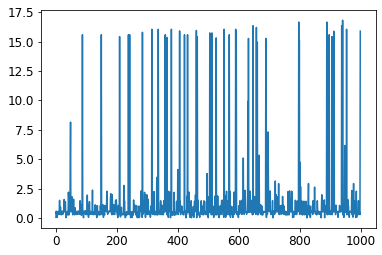

In [22]:
plt.plot(score_history, "-")
plt.show()

#### IDQN Testing

In [23]:
env = record_videos(env)
for episode in trange(1, desc="Test episodes"):
    obs, done = env.reset(), False
    developed_obs = {f"vehicle_{i}":obs_[np.newaxis] for i, obs_ in enumerate(obs)}
    while not done:
        action = idqn_agent.act(developed_obs)
        obs, reward, done, info = env.step(tuple(action.values()))
        print(reward)
env.close()
show_videos()

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /ups-marl-benchmark/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Test episodes:   0%|          | 0/1 [00:00<?, ?it/s]

{MDPVehicle #544: [103.24354742   0.        ]: 0.0, MDPVehicle #824: [152.52719763   0.        ]: 0.0, MDPVehicle #512: [177.5509099   8.       ]: 0.04444444444444443}


#### Developing IPPO Agent

In [41]:
def lecun_init(layer, gain=1):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        pfrl.initializers.init_lecun_normal(layer.weight, gain)
        nn.init.zeros_(layer.bias)
    else:
        pfrl.initializers.init_lecun_normal(layer.weight_ih_l0, gain)
        pfrl.initializers.init_lecun_normal(layer.weight_hh_l0, gain)
        nn.init.zeros_(layer.bias_ih_l0)
        nn.init.zeros_(layer.bias_hh_l0)
    return layer

class PFRLPPOAgent(Agent):
    def __init__(self, config, obs_space, act_space):
        super().__init__()

        def conv2d_size_out(size, kernel_size=2, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1

        h = conv2d_size_out(obs_space[1])
        w = conv2d_size_out(obs_space[2])

        self.model = nn.Sequential(
            lecun_init(nn.Conv2d(obs_space[0], 64, kernel_size=(2, 2))),
            nn.ReLU(),
            nn.Flatten(),
            lecun_init(nn.Linear(h*w*64, 64)),
            nn.ReLU(),
            lecun_init(nn.Linear(64, 64)),
            nn.ReLU(),
            Branched(
                nn.Sequential(
                    lecun_init(nn.Linear(64, act_space), 1e-2),
                    SoftmaxCategoricalHead()
                ),
                lecun_init(nn.Linear(64, 1))
            )
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2.5e-4, eps=1e-5)
        self.agent = PPO(self.model, self.optimizer,
                         phi=lambda x: np.asarray(x, dtype=np.float32),
                         clip_eps=0.1,
                         clip_eps_vf=None,
                         update_interval=1024,
                         minibatch_size=256,
                         epochs=4,
                         standardize_advantages=True,
                         entropy_coef=0.001,
                         max_grad_norm=0.5)

    def act(self, observation):
        return self.agent.act(observation)

    def observe(self, observation, reward, done, info):
        self.agent.observe(observation, reward, done, False)

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path+'.pt')

In [42]:
class IPPO(IndependentAgent):
    def __init__(self, config, obs_act):
        super().__init__(config, obs_act)
        for key in obs_act:
            obs_space = obs_act[key][0]
            act_space = obs_act[key][1]
            self.agents[key] = PFRLPPOAgent(config, obs_space, act_space)

In [43]:
config = {'BATCH_SIZE': 32,
'GAMMA': 0.8,
'EPS_START': 1.0,
'EPS_END': 0.0,
'TARGET_UPDATE': 100,
'steps': 1.0,
'log_dir': 'ippo_logs/'}

In [44]:
controlled_vehicles = 3
actions = 5
observation_space_batched = (1, 10, 6)
obs_act = {f"vehicle_{i}":(observation_space_batched, actions) for i in range(controlled_vehicles)}

In [45]:
ippo_agent = IPPO(config= config, obs_act= obs_act)

#### IPPO Training Loop

In [46]:
EPISODES = 1000
store_at_episodes = [1, 10, 50, 250]

EPISODE_DURATION = 40

In [47]:
img_frames = []
reward_hist = []
score_history = []

for episode in trange(EPISODES, desc= "Training Episodes"):
    img_frames_per_episode = []

    step_reward = []
    
    scores = []
    score = 0
    
    done = False
    store = False
    
    obs = env.reset()
    developed_obs = {f"vehicle_{i}":obs_[np.newaxis] for i, obs_ in enumerate(obs)}
    
    if episode in store_at_episodes:
        store = True
        
    i = 0
    while not done:
        # shows gif of each episode in jupyt
        # Dispatch the observations to the model to get the tuple of actions
        if store:
            img = env.render(mode="rgb_array")
            img_frames_per_episode.append(img)
            
        action = ippo_agent.act(developed_obs)
        full_action = tuple(action.values())
        # Execute the actions
        next_obs, rewards, done, info = env.step(full_action)
        done = any(tuple([info[vehicle]["crashed"] for vehicle in info if not (vehicle == "eps")]))
        if i > EPISODE_DURATION:
            break
            
        if store:
            img = env.render(mode="rgb_array")
            img_frames_per_episode.append(img)

        rewards = {f"vehicle_{i}": reward for i, reward in enumerate(rewards.values())}
        info["eps"] += 1
        
        avg_cars_reward = np.mean(np.array(list(rewards.values())))
        score += avg_cars_reward
        scores.append(score)
        step_reward.append(avg_cars_reward)
        next_obs_full = {f"vehicle_{i}":obs[np.newaxis] for i, obs in enumerate(next_obs)}
        
        # Update the model with the transitions observed by each agent
        ippo_agent.observe(next_obs_full, rewards, done, info)
        env.render()
        i += 1
    ep_reward = np.mean(step_reward)
    score_history.append(np.mean(scores))
    print(f"Episode: {episode}/{EPISODES}; avg_reward: {ep_reward}, score: {np.mean(scores)}")
    #print(alg.get_statistics())
    if store:
        img_frames.append(img_frames_per_episode)
    reward_hist.append(ep_reward)

Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode: 0/1000; avg_reward: 0.5882497985659111, score: 0.5882497985659111
Episode: 1/1000; avg_reward: 0.49787907409718724, score: 0.49787907409718724
Episode: 2/1000; avg_reward: 0.5475635627945613, score: 0.5475635627945613
Episode: 3/1000; avg_reward: 0.31376896189611175, score: 0.31376896189611175
Episode: 4/1000; avg_reward: 0.6345838231449461, score: 1.0309835212146716
Episode: 5/1000; avg_reward: 0.2732741419718294, score: 0.2732741419718294
Episode: 6/1000; avg_reward: 0.562962962962963, score: 0.562962962962963
Episode: 7/1000; avg_reward: 0.29629629629629634, score: 0.29629629629629634
Episode: 8/1000; avg_reward: 0.5586746739056724, score: 0.9731971960436938
Episode: 9/1000; avg_reward: 0.3473567592477027, score: 0.3473567592477027
Episode: 10/1000; avg_reward: 0.33994935184029523, score: 0.33994935184029523
Episode: 11/1000; avg_reward: 0.25264324075229727, score: 0.25264324075229727
Episode: 12/1000; avg_reward: 0.022222222222222216, score: 0.022222222222222216
Episode: 1

Episode: 108/1000; avg_reward: 0.04444444444444443, score: 0.04444444444444443
Episode: 109/1000; avg_reward: 0.3037037037037037, score: 0.3037037037037037
Episode: 110/1000; avg_reward: 0.6362456481365916, score: 0.6362456481365916
Episode: 111/1000; avg_reward: 0.26745805556711216, score: 0.26745805556711216
Episode: 112/1000; avg_reward: 0.27348948872048723, score: 0.27348948872048723
Episode: 113/1000; avg_reward: 0.28148148148148144, score: 0.28148148148148144
Episode: 114/1000; avg_reward: 0.26745805556711205, score: 0.26745805556711205
Episode: 115/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 116/1000; avg_reward: 0.26666666666666666, score: 0.26666666666666666
Episode: 117/1000; avg_reward: 0.5918012036921471, score: 0.5918012036921471
Episode: 118/1000; avg_reward: 0.8044908498503818, score: 2.078583087444253
Episode: 119/1000; avg_reward: 0.2962962962962962, score: 0.2962962962962962
Episode: 120/1000; avg_reward: 0.5843937962847398, score: 0.58439

Episode: 214/1000; avg_reward: 0.6708646322468845, score: 1.0709680340203138
Episode: 215/1000; avg_reward: 0.5986240257459676, score: 0.5986240257459676
Episode: 216/1000; avg_reward: 0.02962962962962962, score: 0.02962962962962962
Episode: 217/1000; avg_reward: 0.28909963427274804, score: 0.28909963427274804
Episode: 218/1000; avg_reward: 0.6993590546056921, score: 1.4849430184178674
Episode: 219/1000; avg_reward: 0.33994935184029534, score: 0.33994935184029534
Episode: 220/1000; avg_reward: 0.5703703703703704, score: 0.5703703703703704
Episode: 221/1000; avg_reward: 0.504495092604149, score: 0.504495092604149
Episode: 222/1000; avg_reward: 0.7329376388831106, score: 1.1732826851736287
Episode: 223/1000; avg_reward: 0.6324133414995387, score: 0.6324133414995387
Episode: 224/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 225/1000; avg_reward: 0.3177271296180731, score: 0.3177271296180731
Episode: 226/1000; avg_reward: 0.5766086070706041, score: 0.576608607070

Episode: 321/1000; avg_reward: 0.7470550812072428, score: 1.5731959351651785
Episode: 322/1000; avg_reward: 0.022222222222222216, score: 0.022222222222222216
Episode: 323/1000; avg_reward: 0.7163427449083393, score: 1.9573646894730998
Episode: 324/1000; avg_reward: 0.5025166203530356, score: 0.9791073147801452
Episode: 325/1000; avg_reward: 0.724872570966896, score: 1.1612216208769168
Episode: 326/1000; avg_reward: 0.39121661833856036, score: 0.39121661833856036
Episode: 327/1000; avg_reward: 0.48306425928237234, score: 0.48306425928237234
Episode: 328/1000; avg_reward: 0.6601188889677873, score: 1.042391759349714
Episode: 329/1000; avg_reward: 0.6348809501688775, score: 1.0278692372116929
Episode: 330/1000; avg_reward: 0.7424419282863289, score: 1.5767460332207481
Episode: 331/1000; avg_reward: 0.2888888888888889, score: 0.2888888888888889
Episode: 332/1000; avg_reward: 0.29096215432030265, score: 0.29096215432030265
Episode: 333/1000; avg_reward: 0.5193099074189639, score: 0.51930990

Episode: 427/1000; avg_reward: 0.2808968961278946, score: 0.2808968961278946
Episode: 428/1000; avg_reward: 0.5613716419602728, score: 0.5613716419602728
Episode: 429/1000; avg_reward: 0.6516545986491762, score: 1.054773716999293
Episode: 430/1000; avg_reward: 0.6206394444213313, score: 0.6206394444213313
Episode: 431/1000; avg_reward: 0.5633050157514499, score: 0.5633050157514499
Episode: 432/1000; avg_reward: 0.2526432407522973, score: 0.2526432407522973
Episode: 433/1000; avg_reward: 0.06327997561618662, score: 0.06327997561618662
Episode: 434/1000; avg_reward: 0.02962962962962962, score: 0.02962962962962962
Episode: 435/1000; avg_reward: 0.017285144430832622, score: 0.017285144430832622
Episode: 436/1000; avg_reward: 0.6140234259143694, score: 0.6140234259143694
Episode: 437/1000; avg_reward: 0.3386690000067644, score: 0.3386690000067644
Episode: 438/1000; avg_reward: 0.5416003704492688, score: 0.9454074759264018
Episode: 439/1000; avg_reward: 0.6319289823512441, score: 0.631928982

Episode: 534/1000; avg_reward: 0.5703703703703704, score: 0.5703703703703704
Episode: 535/1000; avg_reward: 0.2970876851967417, score: 0.2970876851967417
Episode: 536/1000; avg_reward: 0.36217157406251754, score: 0.36217157406251754
Episode: 537/1000; avg_reward: 0.577193192424191, score: 0.577193192424191
Episode: 538/1000; avg_reward: 0.7216159687544219, score: 1.1512455983840515
Episode: 539/1000; avg_reward: 0.5341247222337788, score: 0.5341247222337788
Episode: 540/1000; avg_reward: 0.8271625062733192, score: 1.7268377370172274
Episode: 541/1000; avg_reward: 0.29629629629629634, score: 0.29629629629629634
Episode: 542/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 543/1000; avg_reward: 0.24523583334488988, score: 0.24523583334488988
Episode: 544/1000; avg_reward: 0.6669333625751486, score: 1.0707404680522816
Episode: 545/1000; avg_reward: 0.5415321296411862, score: 0.5415321296411862
Episode: 546/1000; avg_reward: 0.5415321296411862, score: 0.541532129641

Episode: 640/1000; avg_reward: 0.03703703703703703, score: 0.03703703703703703
Episode: 641/1000; avg_reward: 0.5764018035237455, score: 0.5764018035237455
Episode: 642/1000; avg_reward: 0.7179304052127581, score: 1.1432717457850972
Episode: 643/1000; avg_reward: 0.5697857850167836, score: 0.5697857850167836
Episode: 644/1000; avg_reward: 0.5986240257459676, score: 0.5986240257459676
Episode: 645/1000; avg_reward: 0.6214308333217767, score: 0.6214308333217767
Episode: 646/1000; avg_reward: 0.2957117109427094, score: 0.2957117109427094
Episode: 647/1000; avg_reward: 0.7074074074074075, score: 1.1078031018576302
Episode: 648/1000; avg_reward: 0.26745805556711205, score: 0.26745805556711205
Episode: 649/1000; avg_reward: 0.31851851851851853, score: 0.31851851851851853
Episode: 650/1000; avg_reward: 0.6428616666435536, score: 0.6428616666435536
Episode: 651/1000; avg_reward: 0.3179339331649317, score: 0.3179339331649317
Episode: 652/1000; avg_reward: 0.7131256818741984, score: 1.1349522096

Episode: 747/1000; avg_reward: 0.2962962962962963, score: 0.2962962962962963
Episode: 748/1000; avg_reward: 0.04977397831856691, score: 0.04977397831856691
Episode: 749/1000; avg_reward: 0.533540136880192, score: 0.533540136880192
Episode: 750/1000; avg_reward: 0.7202398833811203, score: 1.8962743870088437
Episode: 751/1000; avg_reward: 0.735034862115511, score: 4.0986916782832825
Episode: 752/1000; avg_reward: 0.022222222222222216, score: 0.022222222222222216
Episode: 753/1000; avg_reward: 0.5555555555555555, score: 0.5555555555555555
Episode: 754/1000; avg_reward: 0.5795856365136408, score: 0.5795856365136408
Episode: 755/1000; avg_reward: 0.06314711934156379, score: 0.06314711934156379
Episode: 756/1000; avg_reward: 0.5267173148263714, score: 0.5267173148263714
Episode: 757/1000; avg_reward: 0.26005064815970474, score: 0.26005064815970474
Episode: 758/1000; avg_reward: 0.6145819197006562, score: 0.6145819197006562
Episode: 759/1000; avg_reward: 0.5994154146464131, score: 0.599415414

Episode: 854/1000; avg_reward: 0.5409475442875994, score: 0.5409475442875994
Episode: 855/1000; avg_reward: 0.26745805556711216, score: 0.26745805556711216
Episode: 856/1000; avg_reward: 0.28227287038192694, score: 0.28227287038192694
Episode: 857/1000; avg_reward: 0.3473567592477027, score: 0.3473567592477027
Episode: 858/1000; avg_reward: 0.6422883575762849, score: 1.038980348322804
Episode: 859/1000; avg_reward: 0.7431056472680057, score: 1.5607654706049967
Episode: 860/1000; avg_reward: 0.6280468518287387, score: 0.6280468518287387
Episode: 861/1000; avg_reward: 0.3325419444328878, score: 0.3325419444328878
Episode: 862/1000; avg_reward: 0.5555555555555555, score: 0.5555555555555555
Episode: 863/1000; avg_reward: 0.5703703703703703, score: 0.5703703703703703
Episode: 864/1000; avg_reward: 0.7041987994360978, score: 0.7041987994360978
Episode: 865/1000; avg_reward: 0.29629629629629634, score: 0.29629629629629634
Episode: 866/1000; avg_reward: 0.007407407407407405, score: 0.007407407

Episode: 961/1000; avg_reward: 0.5918012036921471, score: 0.5918012036921471
Episode: 962/1000; avg_reward: 0.5918012036921472, score: 0.5918012036921472
Episode: 963/1000; avg_reward: 0.6134388405607825, score: 0.6134388405607825
Episode: 964/1000; avg_reward: 0.26005064815970474, score: 0.26005064815970474
Episode: 965/1000; avg_reward: 0.650269074050961, score: 0.650269074050961
Episode: 966/1000; avg_reward: 0.28888888888888886, score: 0.28888888888888886
Episode: 967/1000; avg_reward: 0.6060314331533752, score: 0.6060314331533752
Episode: 968/1000; avg_reward: 0.577193192424191, score: 0.577193192424191
Episode: 969/1000; avg_reward: 0.31052652575752426, score: 0.31052652575752426
Episode: 970/1000; avg_reward: 0.04444444444444443, score: 0.04444444444444443
Episode: 971/1000; avg_reward: 0.051851851851851836, score: 0.051851851851851836
Episode: 972/1000; avg_reward: 0.31052652575752426, score: 0.31052652575752426
Episode: 973/1000; avg_reward: 0.5267173148263714, score: 0.526717

#### Plotting Score In Function of Episodes

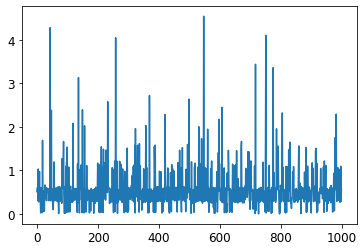

In [48]:
plt.plot(score_history, "-")
plt.show()

#### IPPO Testing

In [ ]:
env = record_videos(env)
for episode in trange(1, desc="Test episodes"):
    obs, done = env.reset(), False
    developed_obs = {f"vehicle_{i}":obs_[np.newaxis] for i, obs_ in enumerate(obs)}
    while not done:
        action = idqn_agent.act(developed_obs)
        obs, reward, done, info = env.step(tuple(action.values()))
        print(reward)
env.close()
show_videos()